In [9]:
# ---------- FIRST LEVEL ANALYSIS ------------
# --------------- Default HRF ----------------

#Imports
import os
import glob
import nilearn 
import numpy as np 
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt

from numpy import savetxt
from nilearn import image
from nilearn import masking
from nilearn import plotting, image
from nilearn.maskers import NiftiMasker
from nilearn.maskers import NiftiSpheresMasker
from nilearn.plotting import plot_design_matrix
from nilearn.reporting import get_clusters_table
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.first_level import compute_regressor
from nilearn.glm.first_level import make_first_level_design_matrix
from IPython.display import Markdown, display

# Init variables
init_folder='/home/traaffneu/margal/code/multirat_se/script/'
analysis_folder='/project/4180000.19/multirat_stim/rabies/preprocess'
            
# Data path
template_path ='/groupshare/traaffneu/preclinimg/templates/SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1/SIGMA_Rat_Anatomical_Imaging/SIGMA_Rat_Anatomical_InVivo_Template/SIGMA_InVivo_Brain_Template.nii'
metadata_path ='/home/traaffneu/margal/code/multirat_se/script/table/metadata_stand.tsv'
mask = '/groupshare/traaffneu/preclinimg/templates/SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1/SIGMA_Rat_Anatomical_Imaging/SIGMA_Rat_Anatomical_InVivo_Template/SIGMA_InVivo_Brain_Mask.nii'


# Output directories
output_dir = '/project/4180000.19/multirat_stim/scratch/rabies_test/first_level/'
glover_dir =  os.path.join(output_dir, 'glover/')
spm_dir = os.path.join(output_dir, 'spm/')

glover_matrix_dir = os.path.join(glover_dir, 'matrix/')
glover_image_dir = os.path.join(glover_dir, 'image/')
glover_model_dir = os.path.join(glover_dir, 'model/')
glover_beta_dir = os.path.join(glover_dir, 'beta_estimates/')
glover_residuals_dir = os.path.join(glover_dir, 'residuals/')
glover_effect_var_dir = os.path.join(glover_dir, 'effect_var/')
glover_predic_timeseries_dir = os.path.join(glover_dir, 'predicted_timeseries/')
glover_beta_dir = os.path.join(glover_dir, 'beta_estimates/')
glover_z_score_dir = os.path.join(glover_dir, 'z_score/')

spm_matrix_dir = os.path.join(spm_dir, 'matrix/')
spm_image_dir = os.path.join(spm_dir, 'image/')
spm_model_dir = os.path.join(spm_dir, 'model/')
spm_beta_dir = os.path.join(spm_dir, 'beta_estimates/')
spm_residuals_dir = os.path.join(spm_dir, 'residuals/')
spm_effect_var_dir = os.path.join(spm_dir, 'effect_var/')
spm_predic_timeseries_dir = os.path.join(spm_dir, 'predicted_timeseries/')
spm_z_score_dir = os.path.join(spm_dir, 'z_score/')

if not os.path.exists(output_dir): os.makedirs(output_dir)
if not os.path.exists(glover_matrix_dir): os.makedirs(glover_matrix_dir)
if not os.path.exists(glover_image_dir): os.makedirs(glover_image_dir)
if not os.path.exists(glover_model_dir): os.makedirs(glover_model_dir)
if not os.path.exists(glover_beta_dir): os.makedirs(glover_beta_dir)
if not os.path.exists(glover_residuals_dir): os.makedirs(glover_residuals_dir)
if not os.path.exists(glover_effect_var_dir): os.makedirs(glover_effect_var_dir)
if not os.path.exists(glover_predic_timeseries_dir): os.makedirs(glover_predic_timeseries_dir)
if not os.path.exists(glover_z_score_dir): os.makedirs(glover_z_score_dir)


if not os.path.exists(spm_matrix_dir): os.makedirs(spm_matrix_dir)
if not os.path.exists(spm_image_dir): os.makedirs(spm_image_dir)
if not os.path.exists(spm_model_dir): os.makedirs(spm_model_dir)
if not os.path.exists(spm_beta_dir): os.makedirs(spm_beta_dir)
if not os.path.exists(spm_residuals_dir): os.makedirs(spm_residuals_dir)
if not os.path.exists(spm_effect_var_dir): os.makedirs(spm_effect_var_dir)
if not os.path.exists(spm_predic_timeseries_dir): os.makedirs(spm_predic_timeseries_dir)
if not os.path.exists(spm_z_score_dir): os.makedirs(spm_z_score_dir)

In [10]:
# --- Hrf model to be used ---

""" Define hrf model used for the first analysis
    Options : 
    ---------
    rat_hrf_delay_disp
    rat_hrf_gamma_diff
"""

hrf_function = 'glover'
#hrf_function = 'spm'
print('The chosen HRF model is:', hrf_function)

The chosen HRF model is: glover


In [ ]:
# ---------- FIRST LEVEL ANALYSIS ------------
# --------------- Default HRF ----------------

df = pd.read_csv(metadata_path, sep='\t')
df = df.loc[(df['exclude'] != 'yes')]

print('The chosen HRF model is:', hrf_function)

for index in range(95, 106):
    
    subj_num=str(df.iloc[index]['rat.sub'])[:-2]
    print('index:', index)
    print('subj:', subj_num)
    
    subject_path = glob.glob(analysis_folder + "/sub-0{}_ses-1/bold_datasink/commonspace_bold/*/*/*.nii.gz".format(subj_num, subj_num, subj_num))[0]
    func_img = nib.load(subject_path) 
    
    tr = (df.iloc[index]['func.TR']) 
    n_scans = func_img.shape[3]    
    frame_times = np.arange(n_scans) * tr                              

  # --- Events regressor ---     
    
    n_tr = np.count_nonzero((np.matrix(df.iloc[index]['func.sensory.onset'])))   #count number of stimulation, number of onset
    duration_1_stim = int(df.iloc[index]['func.sensory.duration'].split(',')[0].strip())
       
    onset_metadata = np.matrix(df.iloc[index]['func.sensory.onset']).A[0]        # Get onsets from metadata file
    onsets = onset_metadata 
    
    #if len(onset_metadata) != len(scan_start_times):
        #onsets = onset_metadata 
      #  warning = '**WARNING: number of onset in onset_metadata are diff than number of TR in scan_start_times**'
       # display(Markdown(warning))
    #else:
        #scan_start_times = frame_times[:n_tr]                                        # Get the start times of each scan
        #onsets = onset_metadata - scan_start_times                               # Subtract the start time of each scan
  
    durations = np.matrix(df.iloc[index]['func.sensory.duration']).A[0]
    trial_type = np.ones_like(onsets)
    events = pd.DataFrame({'trial_type': trial_type,'onset': onsets,'duration': durations})
    
    print('TR:', tr)
    print('n stim:', n_tr)
    print('stim duration:', duration_1_stim)
    
    # --- Motion regressors ---

    cofounders_file = 'sub-0{}_ses-1_run-1_bold_RAS_combined_confounds.csv'.format(subj_num)
    cofounders_path = glob.glob(analysis_folder +"/sub-0{}_ses-1/confounds_datasink/confounds_csv/*/*/*.csv".format(subj_num, subj_num, subj_num, subj_num))[0]

    cofounders = pd.read_csv(cofounders_path, sep=',')

    motion_names = ['mov1', 'mov2', 'mov3', 'rot1', 'rot2', 'rot3']
    motion = np.array(cofounders[motion_names])
    
    
    # --- Compute design matrix --- 
   
    design_matrix = make_first_level_design_matrix(frame_times=frame_times, 
                                                   events=events, 
                                                   add_regs=motion, 
                                                   add_reg_names=motion_names, 
                                                   drift_model="polynomial", 
                                                   drift_order=3, 
                                                   hrf_model=hrf_function,
                                                   high_pass=0.01)
    plot_design_matrix(design_matrix) 


    # --- Fitting a first-level model ----  
    
    fmri_glm = FirstLevelModel(t_r=tr,
                               drift_model='polynomial',
                               signal_scaling=False,
                               minimize_memory=False)
    
    fmri_glm = fmri_glm.fit(subject_path, design_matrices=design_matrix)

    residuals = fmri_glm.residuals[0]
    predicted_timeseries = fmri_glm.predicted[0]
        
    # -- Coompute contrasts ---
    
    n_columns = design_matrix.shape[1]
    contrast_val = np.hstack(([1], np.zeros(n_columns - 1)))
    print('Contrasts: ', contrast_val)

    statistical_map = fmri_glm.compute_contrast(contrast_val, output_type='all')
    
    #-- Plot and save as nifti file ---
    
    plot_stat = plotting.plot_stat_map(statistical_map['z_score'], 
                                       bg_img = template_path, 
                                       threshold = 1.9, 
                                       title = 'Rat {}'.format(subj_num))
        
    
    #-- Save outputs --  
    
    if hrf_function == 'glover':
        savetxt(glover_matrix_dir+'matrix_sub-0{}_ses-1.csv'.format(subj_num), design_matrix, delimiter=',')
        nib.save(residuals, glover_residuals_dir+'residuals_sub-0{}_ses-1.nii.gz'.format(subj_num))         #save this to nifti
        nib.save(predicted_timeseries, glover_predic_timeseries_dir+'predicted_timeseries_sub-0{}_ses-1.nii.gz'.format(subj_num))  
        nib.save(statistical_map['z_score'], glover_z_score_dir+'z_score_sub-0{}_ses-1.nii.gz'.format(subj_num))           #save z map
        nib.save(statistical_map['effect_size'], glover_beta_dir+'beta_sub-0{}_ses-1.nii.gz'.format(subj_num))             #save the betaestimates
        nib.save(statistical_map['effect_variance'], glover_effect_var_dir+'effect_var_sub-0{}_ses-1.nii.gz'.format(subj_num))  #save the betaestimates
        plt.savefig(glover_image_dir+'stat_map_sub-0{}_ses-1.png'.format(subj_num))

    elif hrf_function == 'spm':
        savetxt(spm_matrix_dir+'matrix_sub-0{}_ses-1.csv'.format(subj_num), design_matrix, delimiter=',')
        nib.save(residuals, spm_residuals_dir+'residuals_sub-0{}_ses-1.nii.gz'.format(subj_num))         #save this to nifti
        nib.save(predicted_timeseries, spm_predic_timeseries_dir+'predicted_timeseries_sub-0{}_ses-1.nii.gz'.format(subj_num))  
        nib.save(statistical_map['z_score'], spm_z_score_dir+'z_score_sub-0{}_ses-1.nii.gz'.format(subj_num))           #save z map
        nib.save(statistical_map['effect_size'], spm_beta_dir+'beta_sub-0{}_ses-1.nii.gz'.format(subj_num))             #save the betaestimates
        nib.save(statistical_map['effect_variance'], spm_effect_var_dir+'effect_var_sub-0{}_ses-1.nii.gz'.format(subj_num))  #save the betaestimates
        plt.savefig(spm_image_dir+'stat_map_sub-0{}_ses-1.png'.format(subj_num))
  
  
    else:
        print('No file to be saved. Check that hrf_function is well defined.')
    
    

The chosen HRF model is: glover
index: 95
subj: 201100
TR: 1.5
n stim: 7
stim duration: 21
Contrasts:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/home/traaffneu/margal/anaconda3/envs/MultiRatSe/lib/python3.9/site-packages/nilearn/glm/_utils.py:344: RuntimeWarning: divide by zero encountered in true_divide
  return np.where(X <= 0, 0, 1.0 / X)


index: 96
subj: 201101
TR: 1.5
n stim: 7
stim duration: 21
Contrasts:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/home/traaffneu/margal/anaconda3/envs/MultiRatSe/lib/python3.9/site-packages/nilearn/glm/_utils.py:344: RuntimeWarning: divide by zero encountered in true_divide
  return np.where(X <= 0, 0, 1.0 / X)


index: 97
subj: 201102
TR: 1.5
n stim: 7
stim duration: 21
Contrasts:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/home/traaffneu/margal/anaconda3/envs/MultiRatSe/lib/python3.9/site-packages/nilearn/glm/_utils.py:344: RuntimeWarning: divide by zero encountered in true_divide
  return np.where(X <= 0, 0, 1.0 / X)


index: 98
subj: 201103
TR: 1.5
n stim: 7
stim duration: 21
Contrasts:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/home/traaffneu/margal/anaconda3/envs/MultiRatSe/lib/python3.9/site-packages/nilearn/glm/_utils.py:344: RuntimeWarning: divide by zero encountered in true_divide
  return np.where(X <= 0, 0, 1.0 / X)


index: 99
subj: 201104
TR: 1.5
n stim: 7
stim duration: 21
Contrasts:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/home/traaffneu/margal/anaconda3/envs/MultiRatSe/lib/python3.9/site-packages/nilearn/glm/_utils.py:344: RuntimeWarning: divide by zero encountered in true_divide
  return np.where(X <= 0, 0, 1.0 / X)


index: 100
subj: 201105
TR: 1.5
n stim: 7
stim duration: 21
Contrasts:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/home/traaffneu/margal/anaconda3/envs/MultiRatSe/lib/python3.9/site-packages/nilearn/glm/_utils.py:344: RuntimeWarning: divide by zero encountered in true_divide
  return np.where(X <= 0, 0, 1.0 / X)


index: 101
subj: 201106
TR: 1.5
n stim: 7
stim duration: 21
Contrasts:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/home/traaffneu/margal/anaconda3/envs/MultiRatSe/lib/python3.9/site-packages/nilearn/glm/_utils.py:344: RuntimeWarning: divide by zero encountered in true_divide
  return np.where(X <= 0, 0, 1.0 / X)


index: 102
subj: 201107
TR: 1.5
n stim: 7
stim duration: 21
Contrasts:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/home/traaffneu/margal/anaconda3/envs/MultiRatSe/lib/python3.9/site-packages/nilearn/glm/_utils.py:344: RuntimeWarning: divide by zero encountered in true_divide
  return np.where(X <= 0, 0, 1.0 / X)


index: 103
subj: 201108
TR: 1.5
n stim: 7
stim duration: 21


In [19]:
print('TR:', tr)
print('stim duration:', duration_1_stim)
    
print('n_scans', n_scans)
print('onsets', onsets)
print('frame_times', frame_times) 
print('events', events)

TR: 1.0
n stim: 20
stim duration: 6
n_scans 372
onsets [ 16  34  52  70  88 106 124 142 160 178 196 214 232 250 268 286 304 322
 340 358]
frame_times [  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167

In [31]:
#print(onset_metadata)
#print(onset)
#print('scan', n_scans)
#print(duration)
#print(durations)
#print(events)
#print('frame', frame_times)
#array = np.array([*range(8, 1593, 16)])

array = np.array([16,32,48,64,80,96,112,128,144,160,176,192,208,224,240,256,272,288,304,320,336,352,368,384,400,416,432,448,464,480,496,512,528,544,560,576,592,608,624,640,656,672,688,704,720,736,752,768,784,800,816,832,848,864,880,896,912,928,944,960,976,992,1008,1024,1040,1056,1072,1088,1104,1120,1136,1152,1168,1184,1200,1216,1232,1248,1264,1280,1296,1312,1328,1344,1360,1376,1392,1408,1424,1440,1456,1472,1488,1504,1520,1536,1552,1568,1584,])
array_long = np.array([8, 24, 40, 56, 72, 88, 104, 120, 136, 152, 168, 184, 200, 216, 232, 248, 264, 280, 296, 312, 328, 344, 360, 376, 392, 408, 424, 440, 456, 472, 488, 504, 520, 536, 552, 568, 584, 600, 616, 632, 648, 664, 680, 696, 712, 728, 744, 760, 776, 792, 808, 824, 840, 856, 872, 888, 904, 920, 936, 952, 968, 984, 1000, 1016, 1032, 1048, 1064, 1080, 1096, 1112, 1128, 1144, 1160, 1176, 1192, 1208, 1224, 1240, 1256, 1272, 1288, 1304, 1320, 1336, 1352, 1368, 1384, 1400, 1416, 1432, 1448, 1464, 1480, 1496, 1512, 1528, 1544, 1560, 1576, 1592])

array_08 = np.array([26.70, 26.65, 26.62, 26.61, 26.64, 26.71, 26.80, 26.91, 27.03, 27.18, 27.35, 27.51, 27.65, 27.78, 27.91, 28.07, 28.25, 28.42, 28.55, 28.65, 28.76, 28.89, 29.02, 29.14, 29.23, 29.31, 29.39, 29.48, 29.57, 29.64, 29.70, 29.75, 29.80, 29.87, 29.95, 30.05, 30.15, 30.21, 30.22, 30.21, 30.20, 30.20, 30.24, 30.30, 30.39, 30.46, 30.50, 30.50, 30.50, 30.51, 30.52, 30.55, 30.58, 30.62, 30.66, 30.69, 30.70, 30.69, 30.66, 30.64, 30.65, 30.69, 30.73, 30.75, 30.76, 30.77, 30.79, 30.82, 30.84, 30.86, 30.89, 30.92, 30.95, 30.96, 30.94, 30.90, 30.88, 30.90, 30.93, 30.95, 30.95, 30.95, 30.96, 30.99, 31.02, 31.03, 31.03, 31.03, 31.05, 31.08, 31.10, 31.10, 31.09, 31.09, 31.13, 31.18, 31.19, 31.17, 31.14, 31.12, 31.12, 31.13, 31.14, 31.14, 31.14, 31.14, 31.13, 31.13, 31.12, 31.12, 31.12, 31.14, 31.15, 31.17, 31.17, 31.18, 31.19, 31.21, 31.22, 31.22, 31.21, 31.21, 31.21, 31.22, 31.24, 31.25, 31.25, 31.23, 31.19, 31.16, 31.15, 31.16, 31.18, 31.20, 31.22, 31.22, 31.20, 31.19, 31.21, 31.26, 31.30, 31.28, 31.22, 31.16, 31.17, 31.22, 31.27, 31.29, 31.28, 31.26, 31.24, 31.23, 31.23, 31.25, 31.28, 31.30, 31.32, 31.31, 31.28, 31.24, 31.23, 31.26, 31.31, 31.33, 31.30, 31.27, 31.26, 31.30, 31.35, 31.37, 31.37, 31.35, 31.31, 31.28, 31.26, 31.27, 31.30, 31.32, 31.33, 31.33, 31.35, 31.34, 31.23, 30.95, 30.45, 29.72, 28.77, 27.67, 26.52, 25.40, 24.34, 23.35, 22.43, 21.58, 20.79, 20.06, 19.36, 18.71, 18.11, 17.56, 17.08, 16.65, 16.24, 15.82, 15.40, 15.01, 14.66, 14.35, 14.05, 13.77, 13.50, 13.25, 13.02, 12.79, 12.56, 12.34, 12.14, 11.97, 11.81, 11.64, 11.45, 11.25, 11.04, 10.83, 10.63, 10.43, 10.24, 10.07, 9.94, 9.82, 9.71, 9.58, 9.43, 9.31, 9.21, 9.13, 9.05, 8.97, 8.87, 8.74, 8.61, 8.52, 8.55, 8.67, 8.86, 9.11, 9.44, 9.86, 10.41, 11.12, 12.03, 13.15, 14.50, 16.07, 17.82, 19.68, 21.57, 23.34, 24.82, 25.89, 26.62, 27.12, 27.48, 27.73, 27.91, 28.04, 28.12, 28.18, 28.24, 28.31, 28.41, 28.53, 28.61, 28.64, 28.64, 28.63, 28.63, 28.66, 28.70, 28.77, 28.83, 28.87, 28.90, 28.90, 28.89, 28.89, 28.92, 28.99, 29.07, 29.13, 29.15, 29.15, 29.16, 29.18, 29.21, 29.23, 29.23, 29.24, 29.28, 29.34, 29.39, 29.42, 29.43, 29.44, 29.47, 29.50, 29.52, 29.53, 29.54, 29.56, 29.60, 29.62, 29.65, 29.67, 29.69, 29.73, 29.77, 29.79, 29.81, 29.82, 29.84, 29.87, 29.91, 29.94, 29.95, 29.97, 29.98, 30.00, 30.02, 30.05, 30.08, 30.09, 30.08, 30.06, 30.08, 30.14, 30.20, 30.24, 30.26, 30.29, 30.35, 30.41, 30.46, 30.47, 30.44, 30.40, 30.35, 30.33, 30.38, 30.47, 30.55, 30.55, 30.50, 30.44, 30.43, 30.46, 30.50, 30.52, 30.53, 30.53, 30.52, 30.52, 30.54, 30.57, 30.60, 30.62, 30.61, 30.62, 30.64, 30.67, 30.68, 30.66, 30.63, 30.62, 30.64, 30.67, 30.70, 30.72, 30.74, 30.76, 30.78, 30.78, 30.76, 30.73, 30.72, 30.76, 30.81, 30.86, 30.86, 30.85, 30.84, 30.84, 30.85, 30.85, 30.85, 30.86, 30.87, 30.89, 30.90, 30.91, 30.90, 30.90, 30.89, 30.89, 30.90, 30.92, 30.94, 30.94, 30.94, 30.92, 30.91, 30.91, 30.92, 30.95, 30.97, 30.99, 30.99, 30.99, 31.00, 31.03, 31.05, 31.06, 31.06, 31.04, 31.04, 31.03, 31.03, 31.02, 31.01, 31.00, 31.01, 31.02, 31.05, 31.04, 30.86, 30.41, 29.69, 28.76, 27.69, 26.55, 25.42, 24.34, 23.34, 22.41, 21.57, 20.79, 20.05, 19.35, 18.70, 18.09, 17.54, 17.05, 16.62, 16.23, 15.86, 15.48, 15.11, 14.75, 14.43, 14.12, 13.84, 13.56, 13.31, 13.09, 12.89, 12.69, 12.48, 12.26, 12.05, 11.86, 11.69, 11.53, 11.36, 11.18, 10.99, 10.80, 10.61, 10.44, 10.27, 10.10, 9.91, 9.72, 9.56, 9.44, 9.34, 9.27, 9.19, 9.11, 9.02, 8.92, 8.83, 8.74, 8.68, 8.67, 8.71, 8.84, 9.09, 9.49, 10.08, 10.89, 11.94, 13.23, 14.74, 16.48, 18.48, 20.76, 23.18, 25.47, 27.40, 28.88, 29.91, 30.51, 30.80, 30.90, 30.93, 30.91, 30.85, 30.76, 30.67, 30.60, 30.54, 30.48, 30.42, 30.34, 30.26, 30.18, 30.12, 30.07, 30.04, 30.02, 29.98, 29.94, 29.89, 29.85, 29.82, 29.80, 29.79, 29.79, 29.79, 29.80, 29.80, 29.79, 29.75, 29.72, 29.73, 29.76, 29.80, 29.81, 29.80, 29.80, 29.83, 29.87, 29.89, 29.86, 29.81, 29.80, 29.86, 29.94, 29.99, 29.99, 29.99, 30.01, 30.06, 30.11, 30.13, 30.12, 30.10, 30.08, 30.06, 30.08, 30.11, 30.15, 30.16, 30.14, 30.13, 30.17, 30.26, 30.34, 30.37, 30.37, 30.35, 30.35, 30.35, 30.36, 30.36, 30.35, 30.35, 30.35, 30.37, 30.42, 30.48, 30.53, 30.53, 30.51, 30.50, 30.52, 30.55, 30.57, 30.58, 30.58, 30.60, 30.64, 30.67, 30.65, 30.61, 30.58, 30.61, 30.68, 30.74, 30.76, 30.75, 30.74, 30.76, 30.78, 30.78, 30.76, 30.73, 30.73, 30.75, 30.78, 30.79, 30.80, 30.80, 30.80, 30.81, 30.84, 30.87, 30.89, 30.90, 30.87, 30.85, 30.86, 30.88, 30.91, 30.91, 30.90, 30.88, 30.87, 30.88, 30.91, 30.97, 31.02, 31.03, 30.99, 30.96, 30.95, 30.98, 31.02, 31.05, 31.05, 31.03, 30.99, 30.95, 30.93, 30.93, 30.95, 30.98, 31.02, 31.06, 31.08, 31.09, 31.10, 31.11, 31.11, 31.12, 31.12, 31.11, 31.10, 31.07, 31.04, 31.04, 31.06, 31.08, 31.09, 31.10, 31.11, 31.13, 31.17, 31.18, 31.15, 31.10, 31.05, 31.03, 31.04, 31.08, 31.09, 30.95, 30.50, 29.77, 28.83, 27.79, 26.71, 25.61, 24.54, 23.51, 22.56, 21.69, 20.91, 20.21, 19.59, 19.01, 18.46, 17.91, 17.39, 16.91, 16.47, 16.06, 15.67, 15.30, 14.93, 14.56, 14.22, 13.95, 13.73, 13.52, 13.30, 13.06, 12.84, 12.66, 12.50, 12.32, 12.10, 11.87, 11.67, 11.52, 11.39, 11.23, 11.04, 10.84, 10.67, 10.52, 10.37, 10.20, 10.03, 9.88, 9.78, 9.69, 9.59, 9.44, 9.30, 9.21, 9.17, 9.15, 9.12, 9.08, 9.07, 9.14, 9.33, 9.70, 10.29, 11.09, 12.08, 13.28, 14.75, 16.57, 18.73, 21.11, 23.59, 26.00, 28.15, 29.86, 31.09, 31.89, 32.29, 32.41, 32.37, 32.26, 32.13, 31.98, 31.83, 31.68, 31.55, 31.43, 31.31, 31.20, 31.09, 30.99, 30.91, 30.84, 30.76, 30.68, 30.59, 30.51, 30.45, 30.40, 30.38, 30.37, 30.36, 30.34, 30.31, 30.27, 30.23, 30.20, 30.16, 30.14, 30.12, 30.12, 30.12, 30.13, 30.13, 30.14, 30.15, 30.16, 30.16, 30.17, 30.17, 30.18, 30.18, 30.19, 30.21, 30.23, 30.25, 30.27, 30.30, 30.33, 30.35, 30.35, 30.33, 30.32, 30.33, 30.36, 30.39, 30.41, 30.44, 30.46, 30.48, 30.50, 30.50, 30.50, 30.51, 30.54, 30.57, 30.59, 30.57, 30.53, 30.51, 30.54, 30.58, 30.63, 30.65, 30.67, 30.67, 30.67, 30.68, 30.70, 30.74, 30.77, 30.78, 30.79, 30.78, 30.77, 30.78, 30.80, 30.85, 30.88, 30.89, 30.86, 30.83, 30.82, 30.82, 30.84, 30.87, 30.89, 30.89, 30.86, 30.84, 30.85, 30.89, 30.95, 30.99, 31.01, 31.01, 31.00, 30.97, 30.94, 30.92, 30.91, 30.93, 30.96, 31.01, 31.04, 31.05, 31.05, 31.03, 31.01, 31.00, 31.01, 31.02, 31.04, 31.04, 31.04, 31.04, 31.04, 31.05, 31.06, 31.08, 31.09, 31.09, 31.10, 31.09, 31.07, 31.05, 31.02, 31.00, 31.00, 31.02, 31.06, 31.11, 31.14, 31.13, 31.11, 31.11, 31.12, 31.14, 31.15, 31.17, 31.17, 31.16, 31.14, 31.11, 31.09, 31.09, 31.12, 31.17, 31.23, 31.25, 31.23, 31.19, 31.14, 31.09, 31.07, 31.08, 31.12, 31.16, 31.19, 31.22, 31.24, 31.20, 31.01, 30.55, 29.82, 28.92, 27.91, 26.85, 25.77, 24.70, 23.67, 22.74, 21.92, 21.17, 20.46, 19.77, 19.14, 19.14, 18.60, 18.14, 17.70, 17.23, 16.75, 16.31])

print(len(array))
print(len(array_long))
#new_array = array + 5
new_array2 = array_08*2
#new_array3 = new_array2 - 2
new_list = ",".join(map(str, new_array2))

#print(new_array)
#print(new_array2)
#print(new_array3)
print(new_list)
print(len(new_list))


99
100
53.4,53.3,53.24,53.22,53.28,53.42,53.6,53.82,54.06,54.36,54.7,55.02,55.3,55.56,55.82,56.14,56.5,56.84,57.1,57.3,57.52,57.78,58.04,58.28,58.46,58.62,58.78,58.96,59.14,59.28,59.4,59.5,59.6,59.74,59.9,60.1,60.3,60.42,60.44,60.42,60.4,60.4,60.48,60.6,60.78,60.92,61.0,61.0,61.0,61.02,61.04,61.1,61.16,61.24,61.32,61.38,61.4,61.38,61.32,61.28,61.3,61.38,61.46,61.5,61.52,61.54,61.58,61.64,61.68,61.72,61.78,61.84,61.9,61.92,61.88,61.8,61.76,61.8,61.86,61.9,61.9,61.9,61.92,61.98,62.04,62.06,62.06,62.06,62.1,62.16,62.2,62.2,62.18,62.18,62.26,62.36,62.38,62.34,62.28,62.24,62.24,62.26,62.28,62.28,62.28,62.28,62.26,62.26,62.24,62.24,62.24,62.28,62.3,62.34,62.34,62.36,62.38,62.42,62.44,62.44,62.42,62.42,62.42,62.44,62.48,62.5,62.5,62.46,62.38,62.32,62.3,62.32,62.36,62.4,62.44,62.44,62.4,62.38,62.42,62.52,62.6,62.56,62.44,62.32,62.34,62.44,62.54,62.58,62.56,62.52,62.48,62.46,62.46,62.5,62.56,62.6,62.64,62.62,62.56,62.48,62.46,62.52,62.62,62.66,62.6,62.54,62.52,62.6,62.7,62.74,62.74,62.7,62.62,6

In [1]:
#! SAVE MODEL !
model = design_matrix.iloc[:, 0]
plt.plot(model)

savetxt(glover_model_dir+'model_sub-0{}_ses-1.csv'.format(subj_num), model, delimiter=',')
#savetxt(spm_model_dir+'model_sub-0{}_ses-1.csv'.format(subj_num), model, delimiter=',')


NameError: name 'design_matrix' is not defined

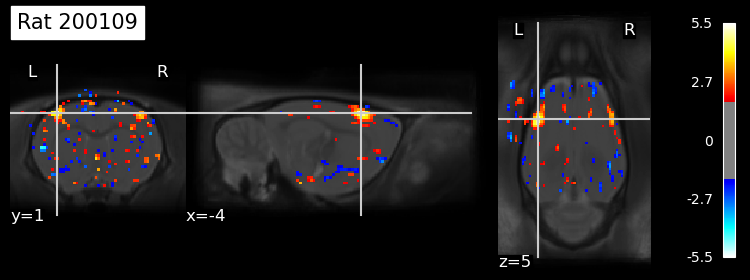

In [11]:
colorbar = plot_stat._cbar                      # get the statistical scale from the plot
vmin, vmax = colorbar.mappable.get_clim()
set_tresh = vmax / 3

plot_stat = plotting.plot_stat_map(statistical_map['z_score'], 
                                       bg_img = template_path, 
                                       threshold = set_tresh, 
                                       title = 'Rat {}'.format(subj_num))
    

In [ ]:
    # -- Extract clusters --

    from nilearn.reporting import get_clusters_table
    from nilearn.maskers import NiftiSpheresMasker

    table = get_clusters_table(statistical_map['z_score'],
                            stat_threshold=3.0,
                            cluster_threshold=20)


    table.set_index("Cluster ID", drop=True)
    coords = table.loc[range(0, len(table)), ['X', 'Y', 'Z']].values                     # get the clusters' x, y, and z coordinates (if want the 4 largest, range(0, 4)
    
    
    masker = NiftiSpheresMasker(coords)                                                  # extracts time series data from a set of spherical regions of interest (ROIs) in a 3D fMRI image
    print(table)
    
    real_timeseries = masker.fit_transform(subject_path)                                 # applies the masker to an fMRI image, outputs 2D numpy array
    predicted_timeseries = masker.fit_transform(fmri_glm.predicted[0])
    clusters_residuals = masker.fit_transform(fmri_glm.residuals[0])
    
    
    #savetxt(clusters_coords_dir+'cluster_timesries_sub-0{}_ses-1.csv'.format(subj_num), coords, delimiter=',')                   # save as .csv file
    #savetxt(clusters_timeseries_dir+'cluster_timesries_sub-0{}_ses-1.csv'.format(subj_num), real_timeseries, delimiter=',')             
    #savetxt(predicted_timeseries_dir+'cluster_predicted_timeseries_sub-0{}_ses-1.csv'.format(subj_num), predicted_timeseries, delimiter=',')       
    #savetxt(clusters_residuals_dir+'clusters_residuals_sub-0{}_ses-1.csv'.format(subj_num), clusters_residuals, delimiter=',')      


   Cluster ID         X         Y         Z  Peak Stat  Cluster Size (mm3)
0           1  4.060001  1.390001  4.335001   8.204623                  29
1           2 -5.839999  1.390001  4.635001   7.761922                  30
2           3  0.160001 -5.809999  5.835001   4.938213                   0
3           4 -0.139999 -2.809999  4.935001   4.918215                   1
4           5 -0.739999 -4.609999  6.135001   4.599831                   0


Cluster 0 peak[4.06000096 1.3900013  4.33500057]

Cluster 1 peak[-5.83999944  1.3900013   4.63500059]

Cluster 2 peak[ 0.1600008  -5.80999899  5.83500063]

Cluster 3 peak[-0.13999921 -2.80999887  4.9350006 ]

Cluster 4 peak[-0.73999923 -4.60999894  6.13500065]



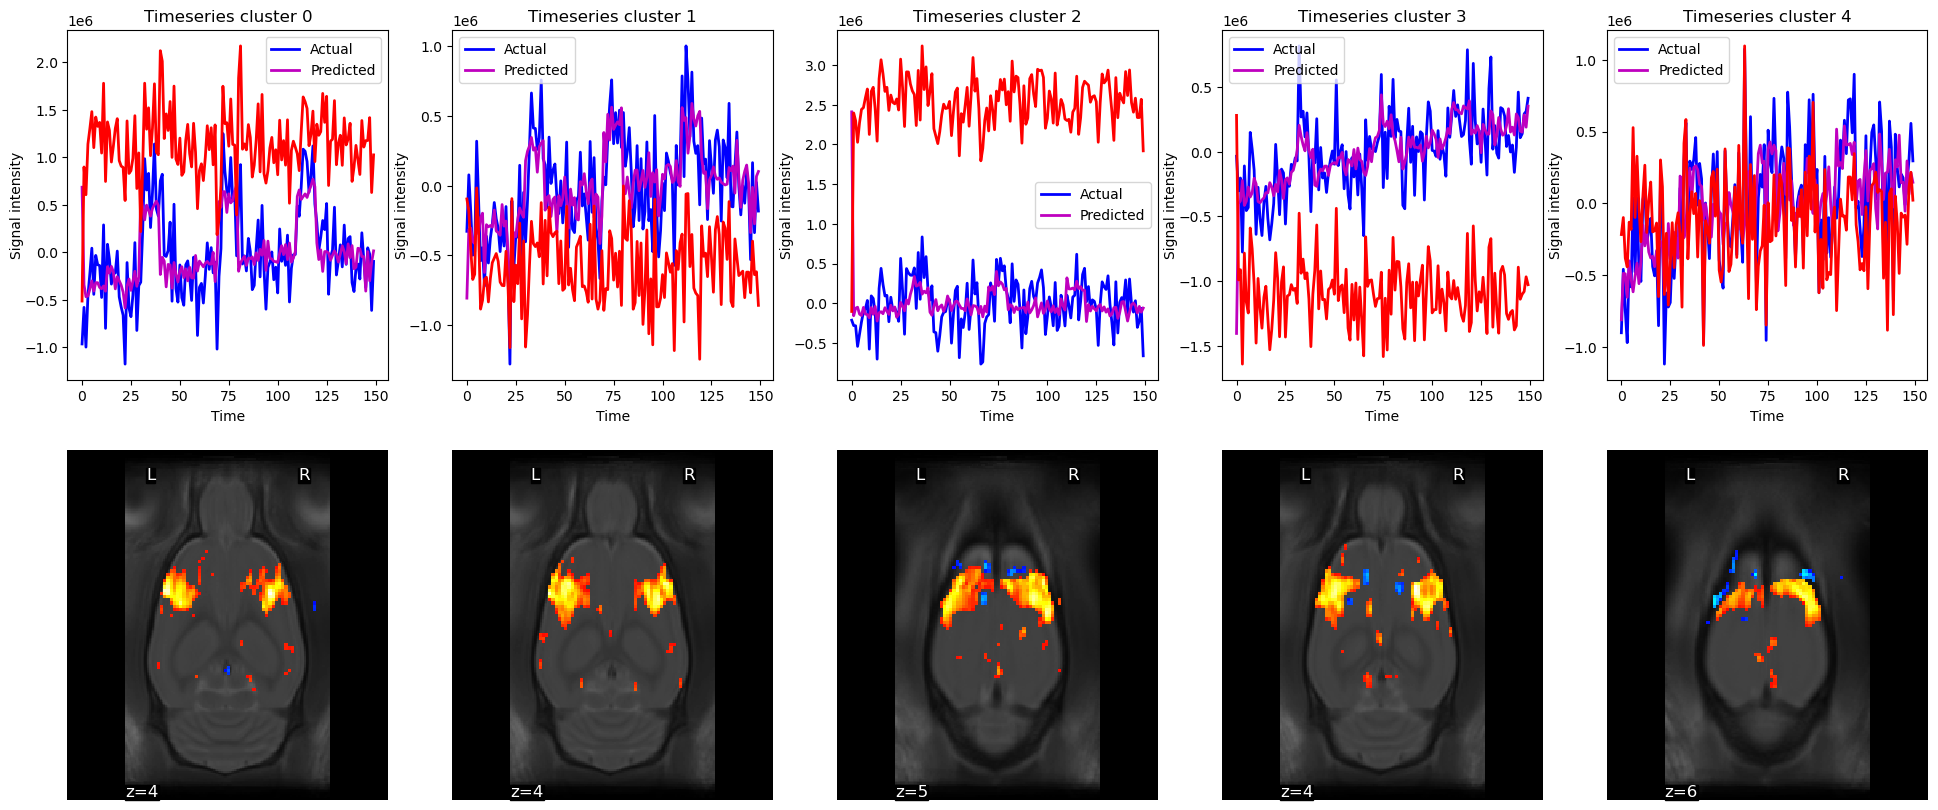

In [ ]:
#Plot timeseries per cluster 

#Correct for differences in baseline levels between the predicted and real time series
predicted_mean = np.mean(predicted_timeseries, axis=0)
real_mean = np.mean(real_timeseries, axis=0)

corrected_predicted = np.subtract(predicted_timeseries, predicted_mean)
corrected_real = np.subtract(real_timeseries, real_mean)

fig1, axs1 = plt.subplots(2, len(table))

for i in range(0, len(table)):
    axs1[0, i].set_title("Timeseries cluster {}".format(i))

    axs1[0, i].plot(corrected_real[:, i], c='b', lw=2, label="Actual")
    axs1[0, i].plot(corrected_predicted[:, i], c="m", ls="-", lw=2, label="Predicted")
    axs1[0, i].plot(clusters_residuals[:, i], c='r', lw=2)
    axs1[0, i].legend()

    axs1[0, i].set_xlabel("Time")
    axs1[0, i].set_ylabel("Signal intensity", labelpad=0)
   
   
# plotting image below the time series
    roi_img = plotting.plot_stat_map(statistical_map['z_score'],
                                    cut_coords=[coords[i][2]],
                                    threshold=3.1,
                                    figure=fig1,
                                    axes=axs1[1, i],
                                    display_mode="z",
                                    colorbar=False,
                                    bg_img = template_path)
    
    fig1.set_size_inches(24, 10)
    print('Cluster {} peak'.format(i)+f'{coords[i]}\n')
  